导入数据

In [281]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

train_data = np.loadtxt("assets/Bayesian_Dataset_train.csv",
                        delimiter=",",
                        dtype='U')
test_data = np.loadtxt("assets/Bayesian_Dataset_test.csv",
                       delimiter=",",
                       dtype='U')


原始数据有连续型的, 有离散型的  
连续型可以直接代数运算; 离散型需要进行编码, 转化为数字再进行运算(如"图书馆 体育馆"-->"0 1").

In [282]:
# 把原始数据统一转化为数值编码
# 0 discrete; 1 continuous; 2 label
data_type = np.array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2])
temp_train = []
temp_test = []
lookup = {}

for i, j in enumerate(data_type):
    if j == 1:
        temp_train.append(train_data[:, i].astype(np.int64))
        temp_test.append(test_data[:, i].astype(np.int64))
    else:
        trd, ted = train_data[:, i], test_data[:, i]
        # 根据训练数据生成字符串到数值的映射字典
        # keys=set()
        # table = dict([(n, m) for m, n in enumerate(set(trd))])
        # lookup[i] = table
        enc = LabelEncoder()
        enc.fit(trd)
        lookup[i] = enc
        # 原始字符串属性转化为离散数值属性
        temp_train.append(enc.transform(trd))
        temp_test.append(enc.transform(ted))
else:
    # 每列重新合并
    train = np.column_stack(tuple(temp_train))
    test = np.column_stack(tuple(temp_test))


- 连续型属性 --> GaussianNB
- 离散型属性 --> CategoricalNB

基本思路为, 借助二者分别计算 $P(x_i|y)$, 最后合并为 $P(y_j)P(X|y_j)$

In [283]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB

# 分离连续特征和离散特征
X1 = train[:, data_type == 1]
X2 = train[:, data_type == 0]
Y = train[:, data_type == 2].ravel()  # label 展平为 1d array

# 连续特征和离散特征分别使用不同的模型预处理
part1 = GaussianNB().fit(X1, Y)
part2 = CategoricalNB(alpha=1.0).fit(X2, Y)

# 测试数据
T1 = test[:, data_type == 1]
T2 = test[:, data_type == 0]
Y0 = test[:, data_type == 2].ravel()


概率计算

取 log, 矩阵对应位置相加即为对应位置概率相乘 (计算代码参考scikit-learn对应[源码](https://github.com/scikit-learn/scikit-learn/blob/f3f51f9b6/sklearn/naive_bayes.py#L1265))


In [284]:
# log P(c) probability of each class.
pc = part2.class_log_prior_  # np.log(part1.class_prior_)

# log P(x|c)

# 连续属性对应的 P
# sigma = part1.var_  # (n_classes, n_features)
# mu = part1.theta_  # (n_classes, n_features)
joint_log_likelihood = []
for i in range(np.size(part1.classes_)):
    n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * part1.var_[i, :]))
    n_ij -= 0.5 * np.sum(
        ((T1 - part1.theta_[i, :])**2) / (part1.var_[i, :]), 1)
    joint_log_likelihood.append(n_ij)

joint_log_likelihood = np.array(joint_log_likelihood).T

# 离散属性对应的 P
jll = np.zeros((T2.shape[0], part2.class_count_.shape[0]))
for i in range(part2.n_features_in_):
    indices = T2[:, i]
    jll += part2.feature_log_prob_[i][:, indices].T

# log P(c) + log P(x|c) total joint log likelihood
total_ll = pc + joint_log_likelihood + jll
total_ll


array([[-25.94720693, -23.46342612],
       [-27.83288322, -32.14922107],
       [-28.74049762, -25.66084304],
       ...,
       [-33.93875017, -42.86827211],
       [-29.30628705, -26.75594013],
       [-24.93613905, -29.03975572]])

进行预测与评估

In [285]:
# predict
Yhat = part1.classes_[np.argmax(total_ll, axis=1)]

# evaluate
precision = sum(Yhat[Y0 == 1]) / sum(Y0 == 1)  #TP/(TP+FP)
recall = sum(Yhat[Y0 == 1]) / sum(Yhat[Yhat == Y0])  # TP/(TP+FN)
F1 = 2 * precision * recall / (precision + recall)

print(precision, recall, F1)


0.7526737967914439 1.0 0.858886346300534


输出结果到csv文件

In [286]:
# output csv
result = lookup[10].inverse_transform(Yhat)  # 预测结果还原为字符串形式
test_data_result = np.concatenate((test_data, result[:, np.newaxis]), axis=1)

np.savetxt('output/Bayesian_Dataset_train_result.csv',
           test_data_result,
           fmt="%s",
           delimiter=",")

# test_data_result

探索CategoricalNaiveBayes中平滑参数$\alpha$对结果的影响
> Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).

c:\Users\45489\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


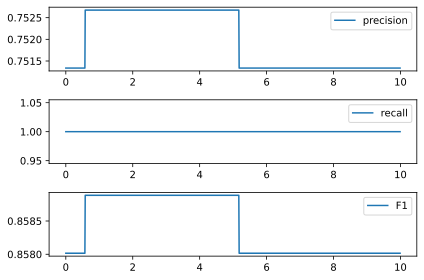

In [288]:
# test alpha
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

precisions =  []
recalls = []
F1s = []

alpha_range=np.arange(0,10,0.01)
for alpha in alpha_range:
    part1 = GaussianNB().fit(X1, Y)
    part2 = CategoricalNB(alpha=alpha).fit(X2, Y)

    pc = part2.class_log_prior_  # np.log(part1.class_prior_)
    joint_log_likelihood = []
    for i in range(np.size(part1.classes_)):
        n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * part1.var_[i, :]))
        n_ij -= 0.5 * np.sum(
            ((T1 - part1.theta_[i, :])**2) / (part1.var_[i, :]), 1)
        joint_log_likelihood.append(n_ij)
    joint_log_likelihood = np.array(joint_log_likelihood).T
    jll = np.zeros((T2.shape[0], part2.class_count_.shape[0]))
    for i in range(part2.n_features_in_):
        indices = T2[:, i]
        jll += part2.feature_log_prob_[i][:, indices].T
    # log P(c) + log P(x|c) total joint log likelihood
    total_ll = pc + joint_log_likelihood + jll
    Yhat = part1.classes_[np.argmax(total_ll, axis=1)]

    precision =  sum(Yhat[Y0 == 1]) / sum(Y0 == 1)
    recall = sum(Yhat[Y0 == 1]) / sum(Yhat[Yhat == Y0])
    precisions.append(precision)
    recalls.append(recall)
    F1s.append(2 * precision * recall / (precision + recall))

plt.subplot(311)
plt.plot(alpha_range,precisions)
plt.legend(["precision"])
plt.subplot(312)
plt.plot(alpha_range,recalls)
plt.legend(["recall"])
plt.subplot(313)
plt.plot(alpha_range,F1s)
plt.legend(["F1"])
plt.tight_layout()